# Entendimento dos dados

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.cluster import KElbowVisualizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve


warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(os.getcwd()+'\\data\\raw\\segmentation_data.csv')

In [3]:
# ajustando nome das colunas
data.columns = data.columns.str.replace(' ', '_').str.lower()

data.head()

,id,sex,marital_status,age,education,income,occupation,settlement_size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               2000 non-null   int64
 1   sex              2000 non-null   int64
 2   marital_status   2000 non-null   int64
 3   age              2000 non-null   int64
 4   education        2000 non-null   int64
 5   income           2000 non-null   int64
 6   occupation       2000 non-null   int64
 7   settlement_size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [5]:
data.isnull().sum()

id                 0
sex                0
marital_status     0
age                0
education          0
income             0
occupation         0
settlement_size    0
dtype: int64

In [6]:
data.duplicated().sum()

0

- Os dados apresentam tipagem correta
- Não há dados duplicados nem dados nulos

In [7]:
data.describe()

,id,sex,marital_status,age,education,income,occupation,settlement_size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


# Análise exploratória dos dados

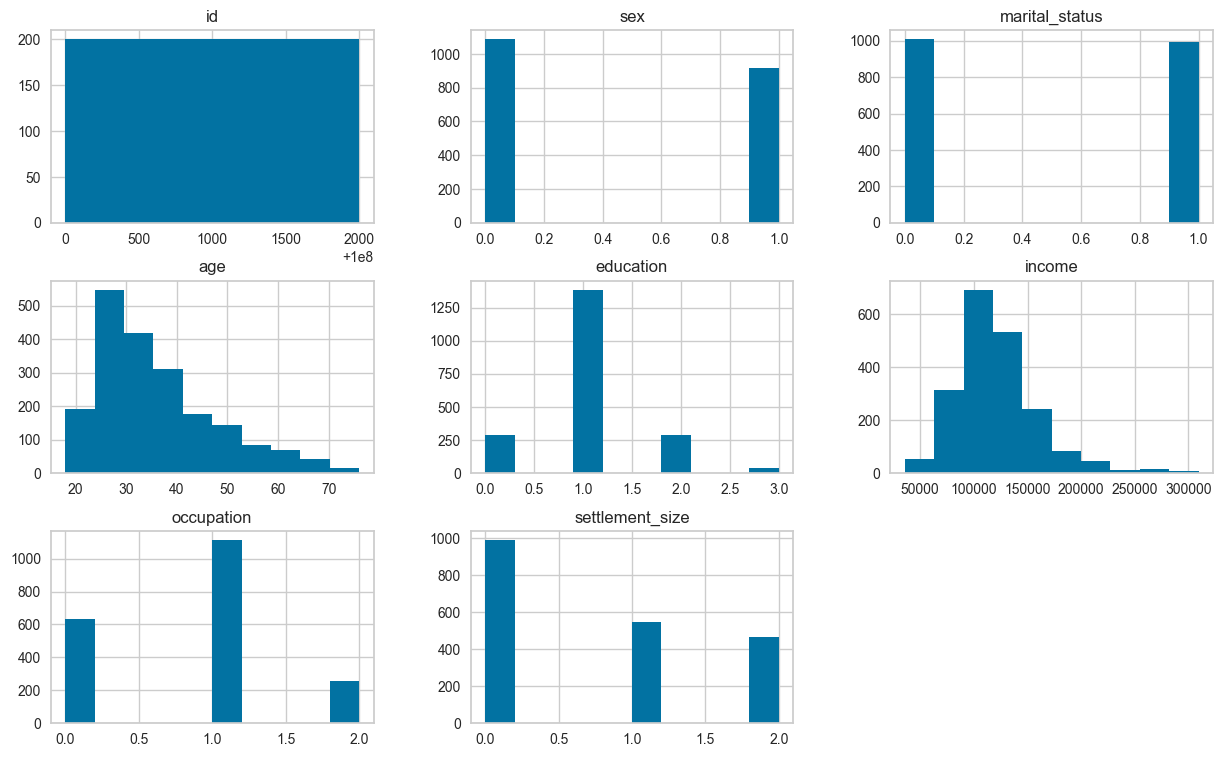

In [8]:
data.hist(figsize=(15,9));

- Analizando préviamente a distribuição dos dados notamos que a coluna `age` e `income` apresentam uma cauda longa e uma certa tentência ao lado esquedo do gráfico. Com o intuito de normalizar essa distribuição utilizaremos o método estatístico de logarítmo a fim de encontra essa normal na distribuição. 
- Este método é utilizado em caso de dados com distribuição desiguais, e funciona diminuindo a escala dos valores.

In [9]:
data['age'] = np.log(data['age'])
data['income'] = np.log(data['income'])

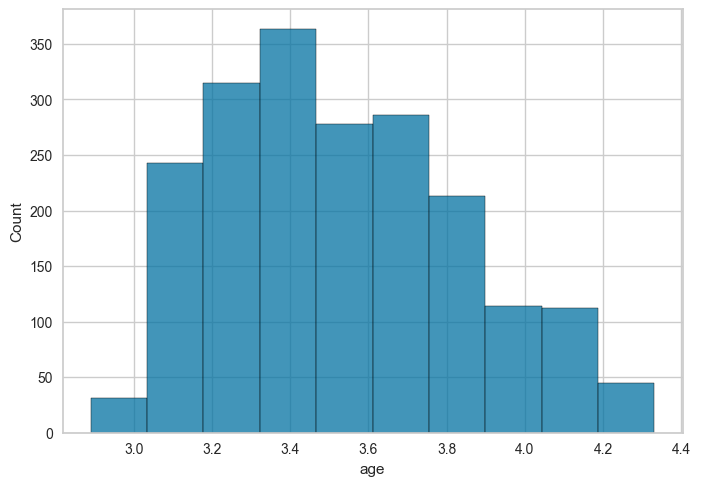

In [10]:
sns.histplot(data['age'], bins=10)
plt.show()

- A maioria dos registros em idade se encontram entre os 25-35 anos.

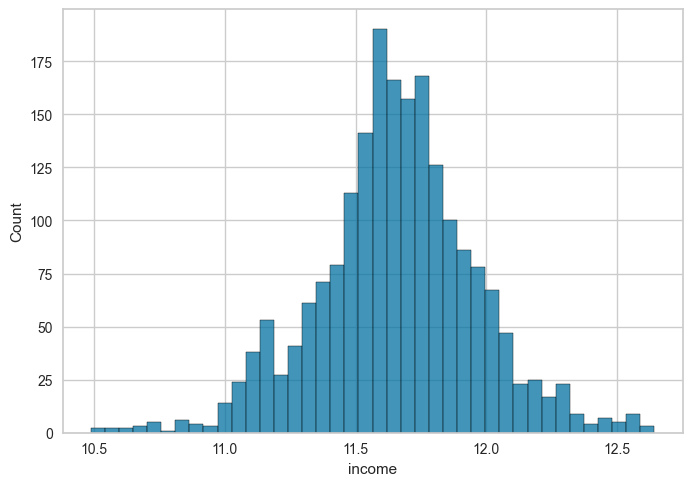

In [11]:
sns.histplot(data['income'])
plt.show()

- A renda média anual é em torno de 100 a 120 mil dólares

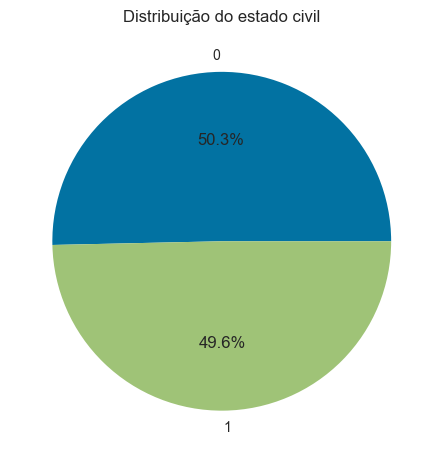

In [12]:
plt.pie(data['marital_status'].value_counts(), labels=data['marital_status'].unique(), autopct='%1.1f%%')
plt.title('Distribuição do estado civil')
plt.show()

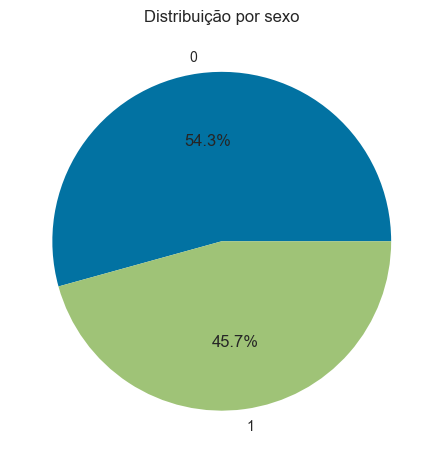

In [13]:
plt.pie(data['sex'].value_counts(), labels=data['sex'].unique(), autopct='%1.1f%%')
plt.title('Distribuição por sexo')
plt.show()

- Há mais homens registrados que mulheres

#### Estado civil  x  Sexo

<Axes: xlabel='marital_status', ylabel='count'>

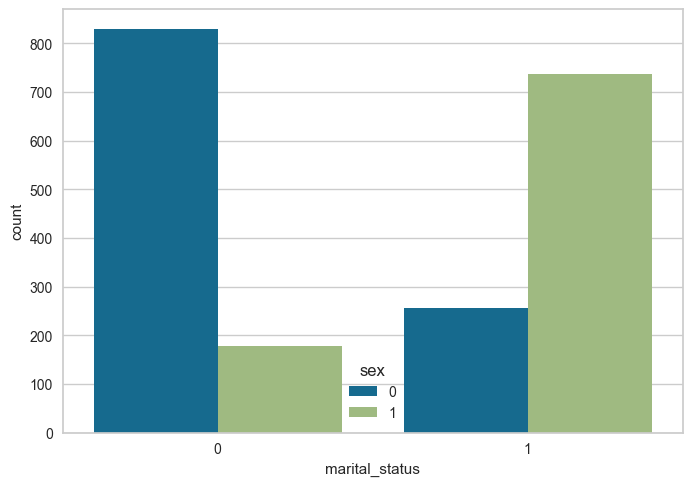

In [14]:
sns.countplot(data=data, x='marital_status', hue='sex')

- Podemos observar que q auntidade de homens solteiros são quase que 4x maior que o número de mulheres solteiras. 
- Já em relacionamento as mulheres apresentam mais que o dobro da quantidade de homens.

<Axes: xlabel='occupation', ylabel='count'>

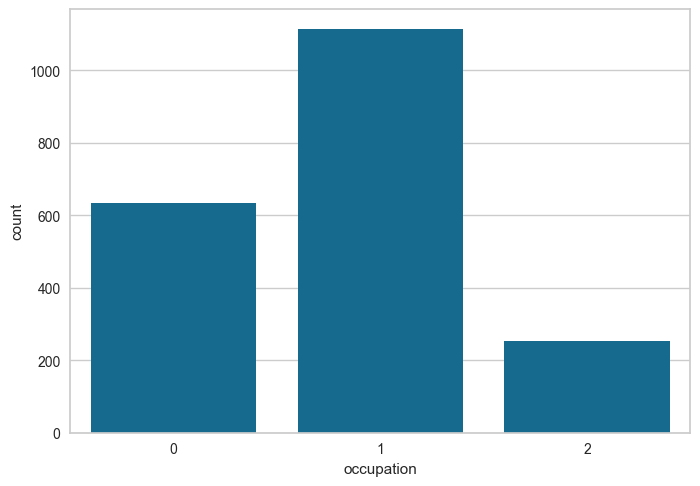

In [15]:
sns.countplot(x='occupation', data=data)

- O maior parte dos nossos clientes são empregados qualificados, em seguida temos os desempregados e por fim altamente qualificados

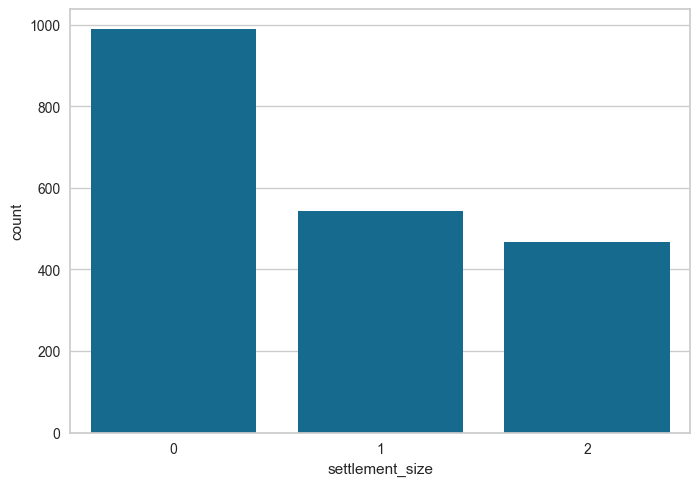

In [16]:
sns.countplot(x='settlement_size', data=data)
plt.show()

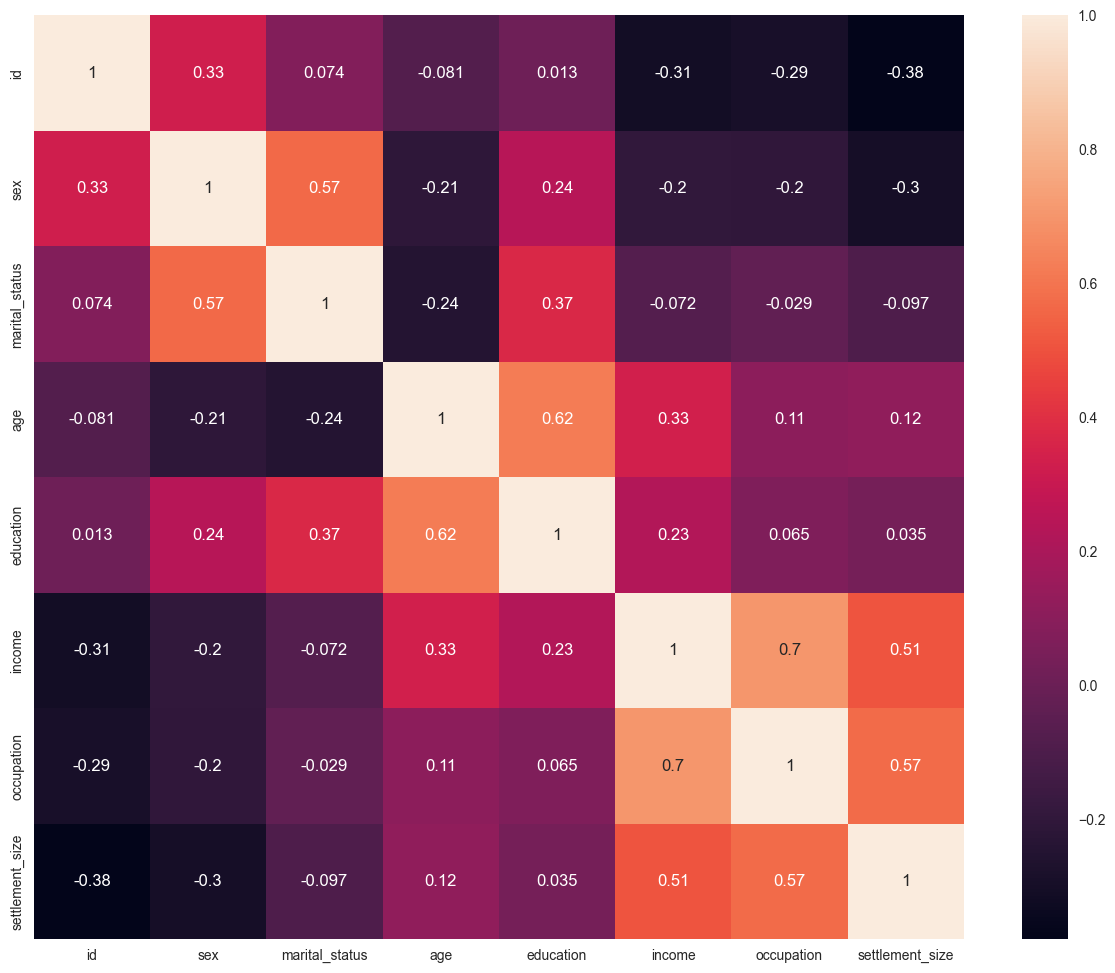

In [17]:
plt.figure(figsize=(15,12))
sns.heatmap(data.corr(), annot=True)
plt.show()

- Notamos uma correlação expressíva entre `occupation` e `income`. O que faz sentido, normalmente quanto maior a renda, melhor a regirão que reside a pessoa. 

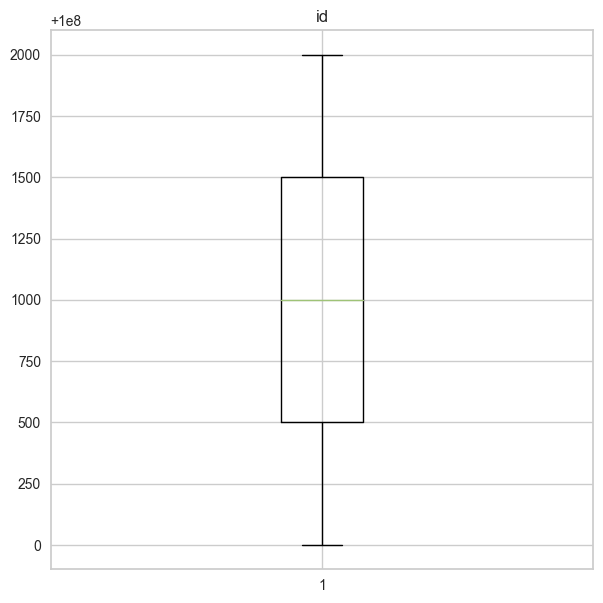

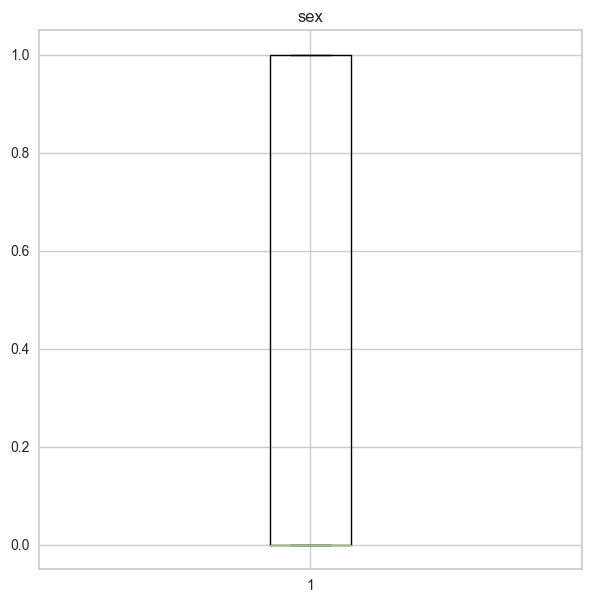

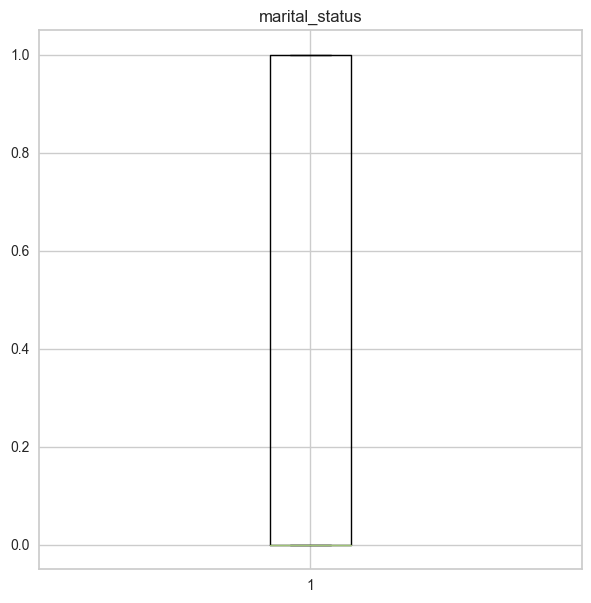

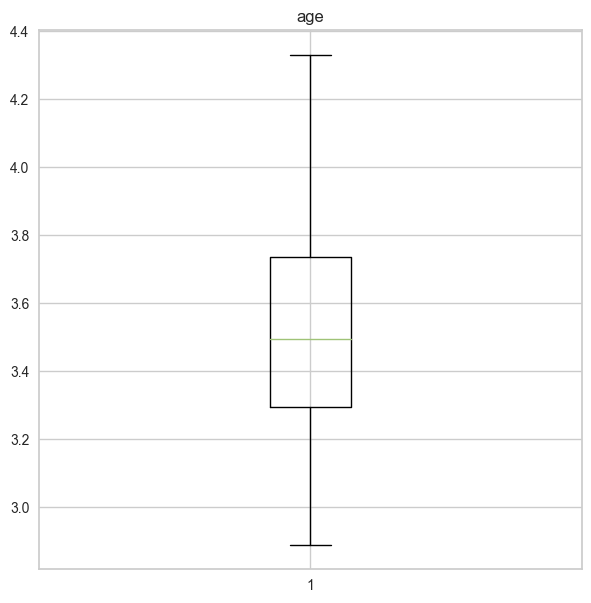

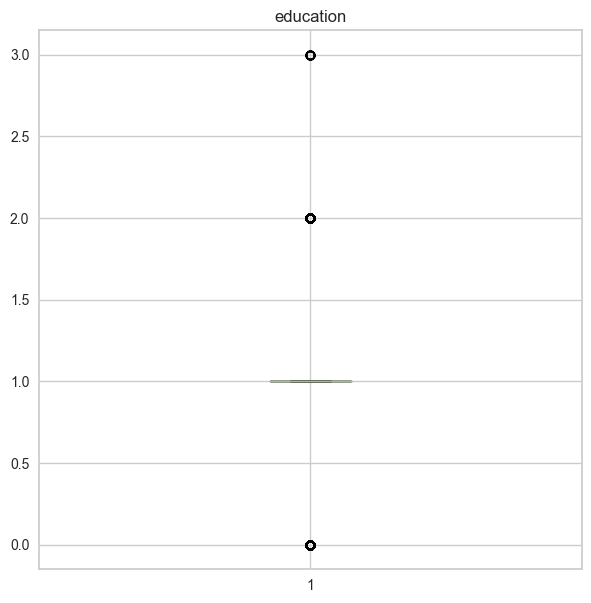

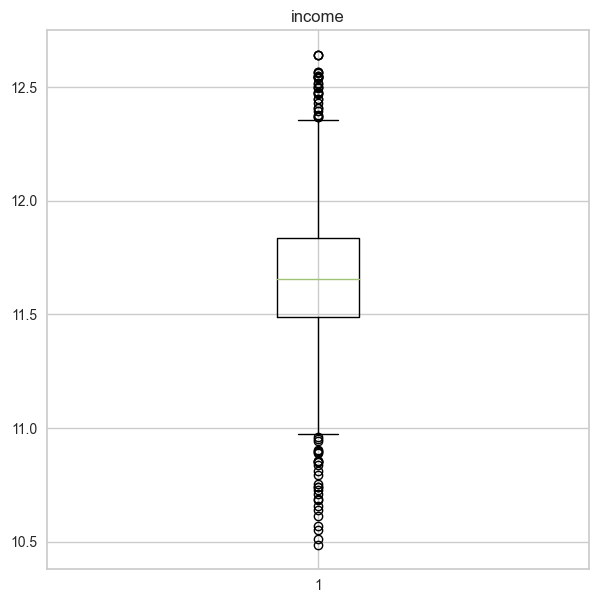

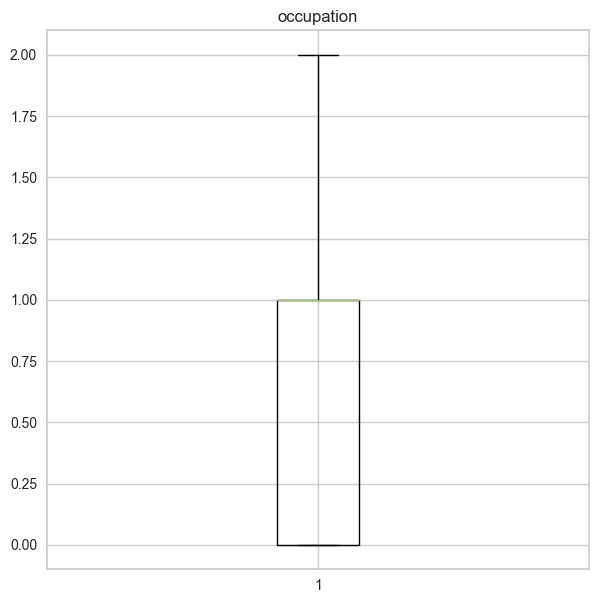

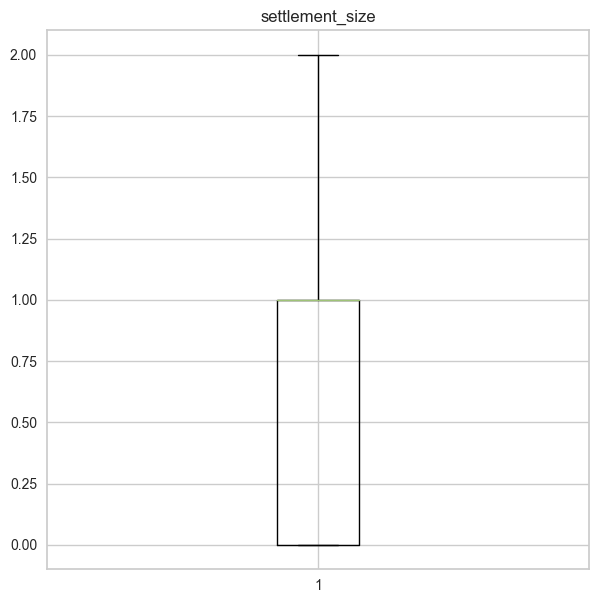

In [18]:
for col in data.columns:
    plt.figure(figsize=(7,7))
    plt.boxplot(data[col])
    plt.title(f'{col}')
    plt.show()

- Nossos dados não possuem outliers

# Modelagem de dados

In [19]:
x = data[['age', 'income']]

sc = RobustScaler()

x = sc.fit_transform(x)

x

array([[ 1.60283513,  0.21943558],
       [-0.91768912,  0.76847333],
       [ 0.89471126, -0.74713668],
       ...,
       [-0.14150231, -0.83957083],
       [-0.72075628, -0.47667503],
       [-0.62836387, -1.51359232]])

## K-means

#### Método de cotovelo para determinar o número de K

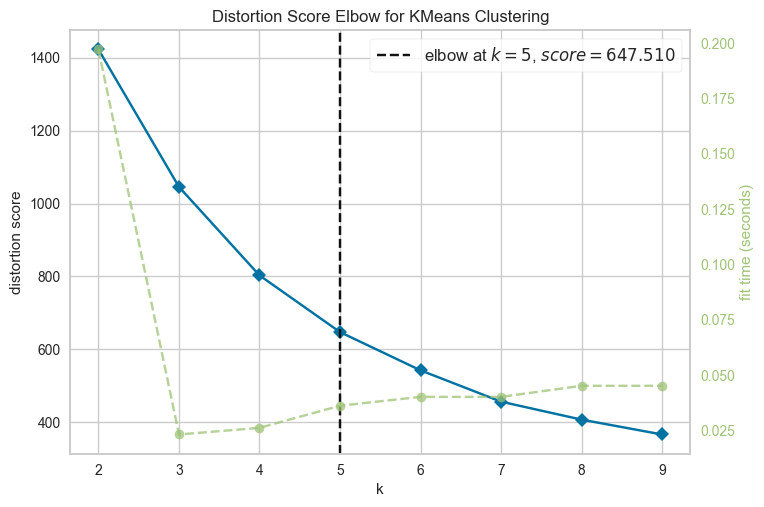

In [20]:
model = KMeans(random_state=42, init='k-means++')
viz = KElbowVisualizer(model, k=(2,10))

viz.fit(x)
viz.show()
plt.show()

- Podemos observar que o melhor valor de K é 5 grupos. Para este estudo usaremos 5, caso fosse um projeto real contactaria-mos com o time de negócios para determinar estes valores.

In [21]:
km = KMeans(n_clusters=5, random_state=42)
x_trasf = km.fit_predict(x)
x_trasf

array([0, 2, 4, ..., 1, 3, 1])

In [22]:
data.loc[:,'cluster'] = x_trasf
data

,id,sex,marital_status,age,education,income,occupation,settlement_size,cluster
0,100000001,0,0,4.204693,2,11.733426,1,2,0
1,100000002,1,1,3.091042,1,11.923531,1,2,2
2,100000003,0,0,3.891820,1,11.398748,0,0,4
3,100000004,0,0,3.806662,1,12.052717,1,1,0
4,100000005,0,0,3.970292,1,11.911910,1,1,0
...,...,...,...,...,...,...,...,...,...
1995,100001996,1,0,3.850148,1,11.724199,0,0,4
1996,100001997,1,1,3.295837,1,11.676268,1,0,3
1997,100001998,0,0,3.433987,0,11.366743,0,0,1
1998,100001999,1,1,3.178054,1,11.492396,0,0,3


In [23]:
# exportando dataset
path = 'c:\\Users\\God\\Desktop\\DieGod\\Projetos\\segmentacao-clientes\\data\\processed\\data_clusterized.csv'
data.to_csv(path, index=False)

## Análise dos clusters

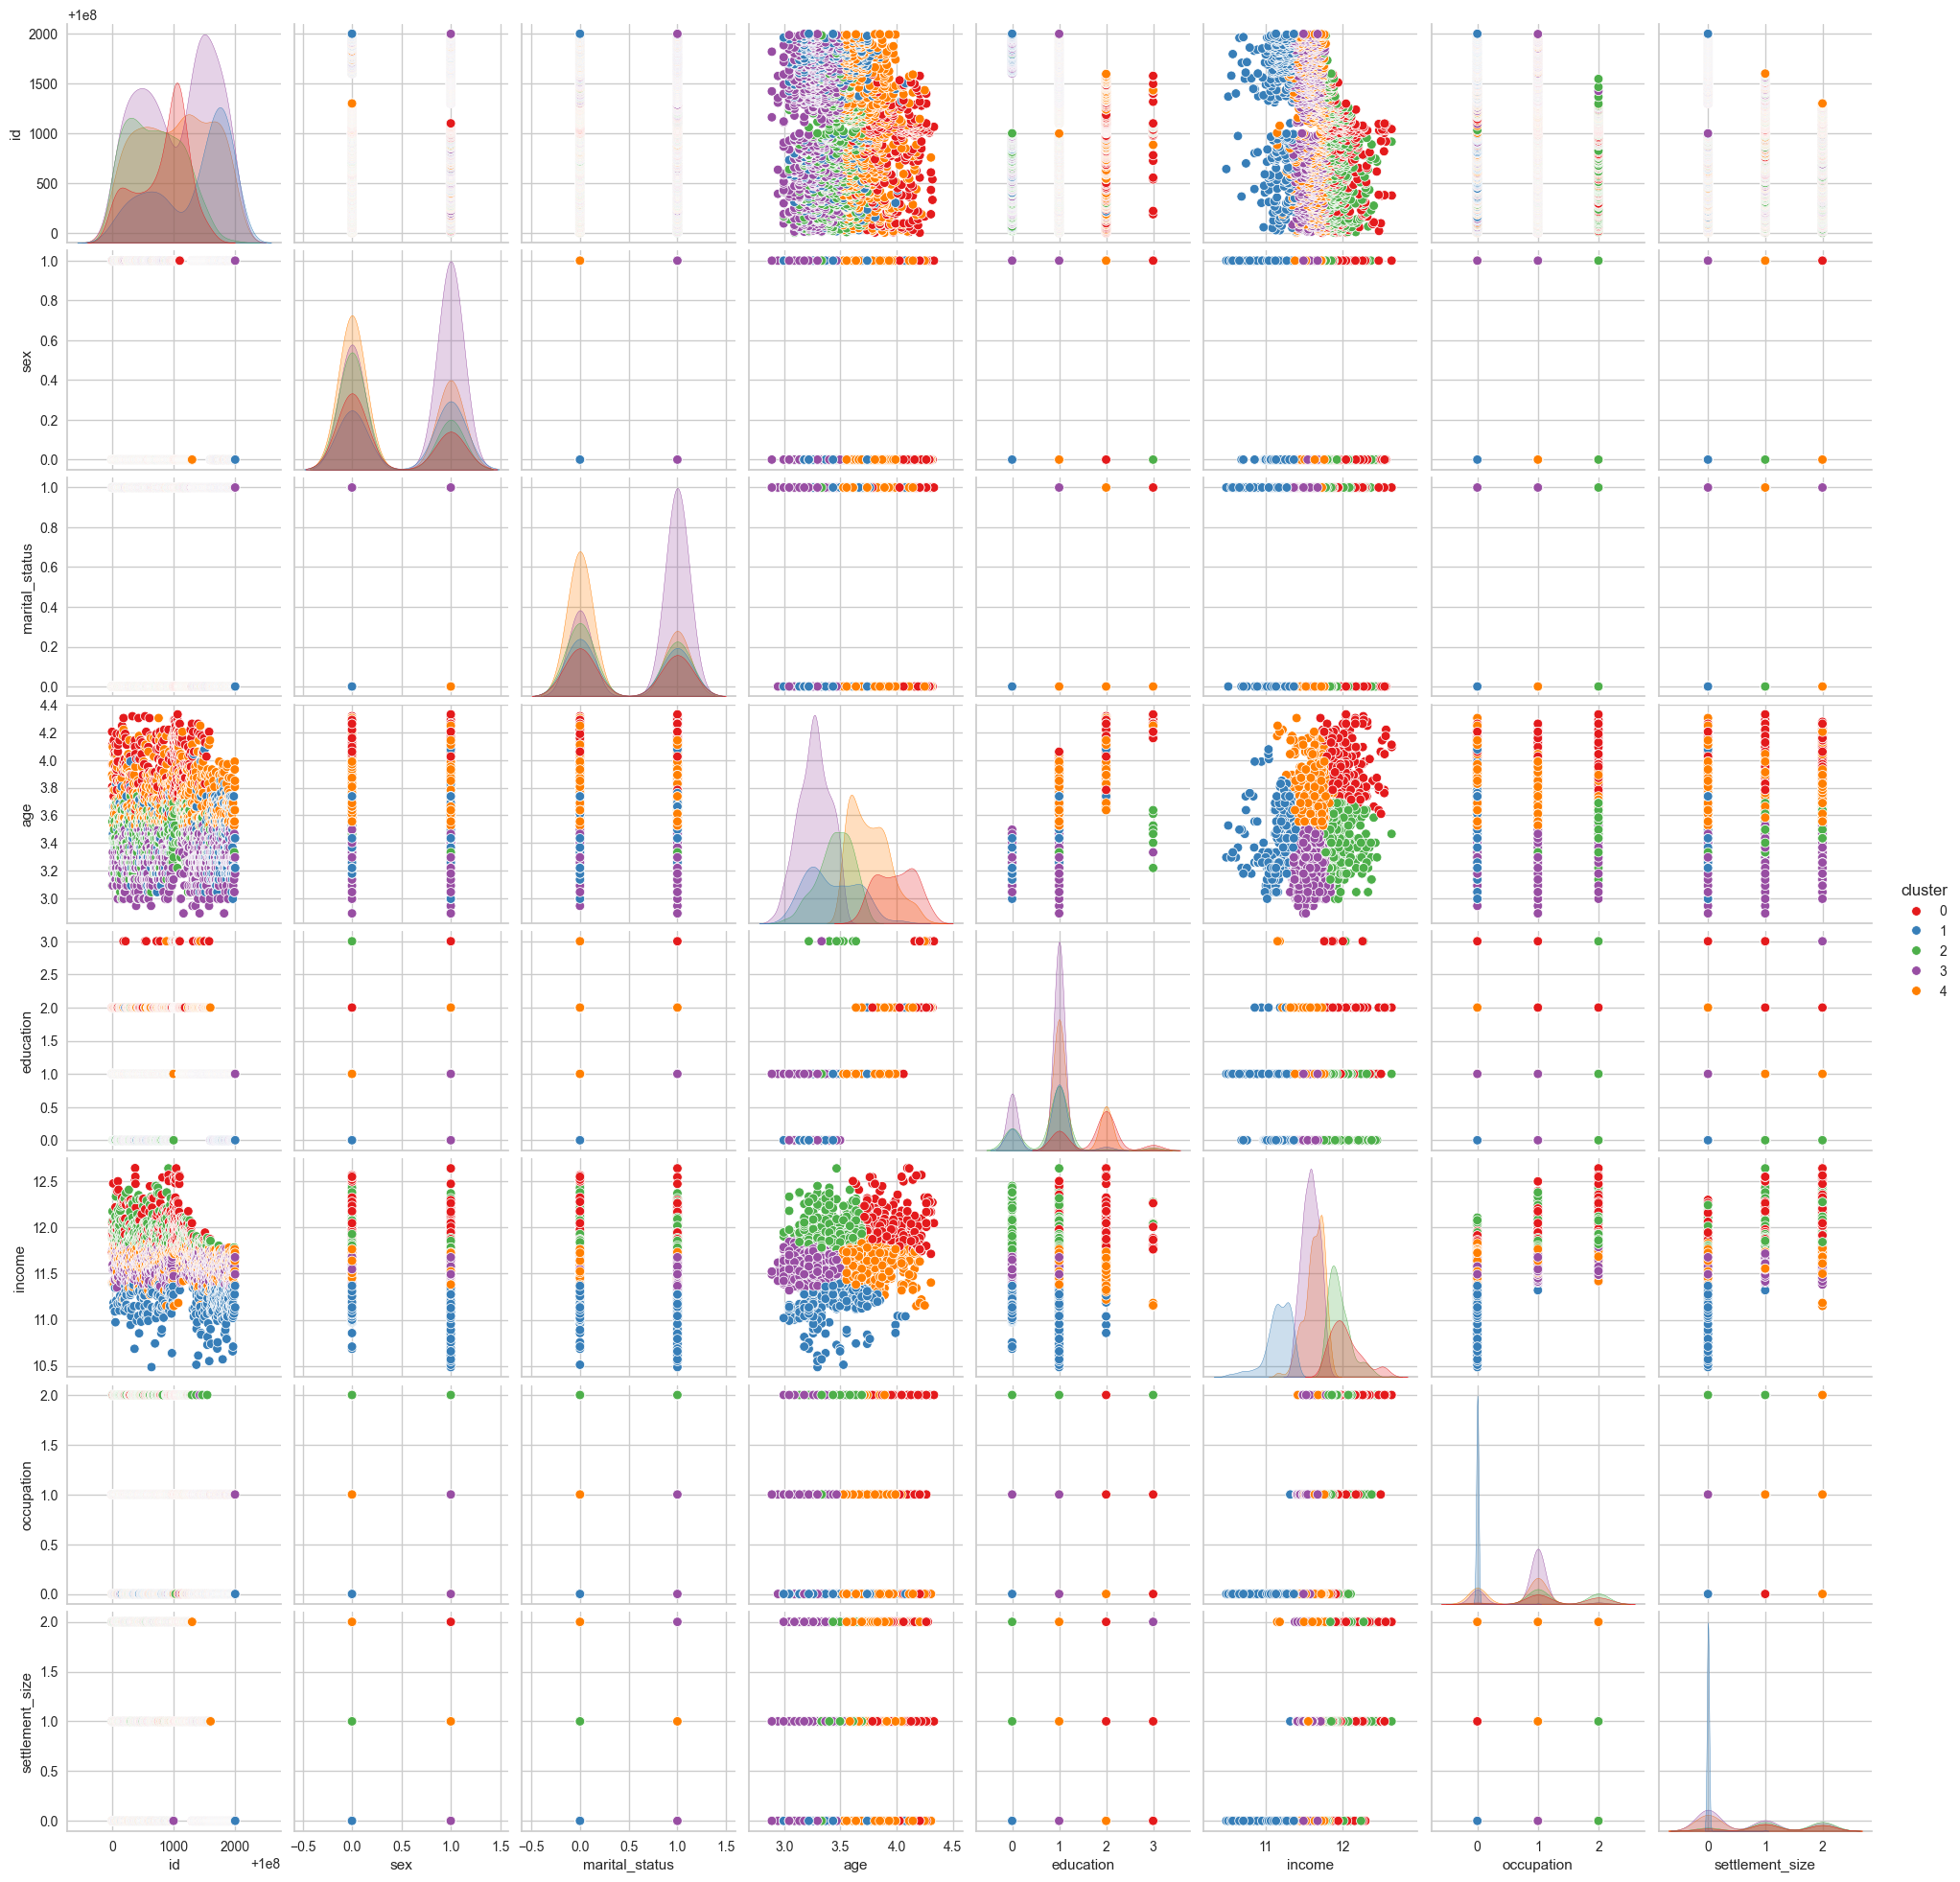

In [24]:
sns.pairplot(data, hue='cluster', palette='Set1')
plt.show()

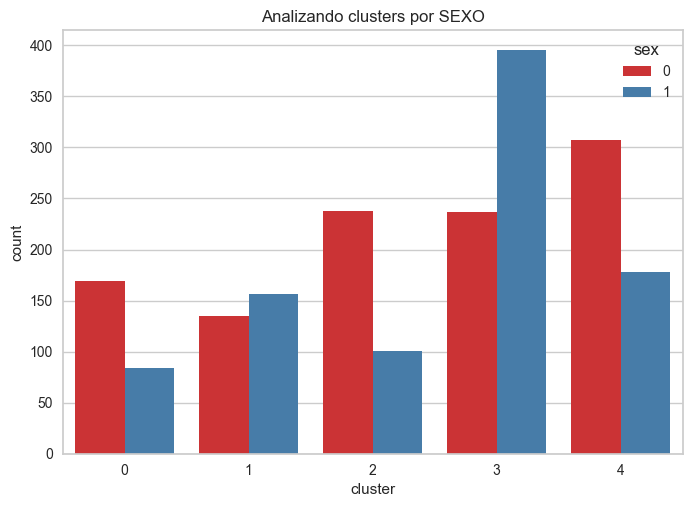

 0 - Homens
 1 - Mulheres


In [25]:
# cluster x sexo
sns.countplot(data=data, x='cluster', hue='sex', palette='Set1')
plt.title('Analizando clusters por SEXO')
plt.show()
print(' 0 - Homens\n 1 - Mulheres')

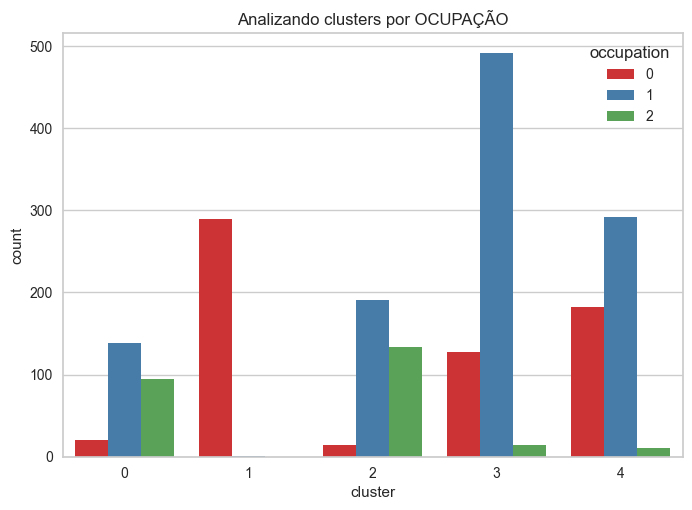

 0 - Desempregado
 1 - Funcionário Qualificado
 2 - Altamente Qualificado


In [26]:
# cluster x ocupação
sns.countplot(data=data, x='cluster', hue='occupation', palette='Set1')
plt.title('Analizando clusters por OCUPAÇÃO')
plt.show()
print(' 0 - Desempregado\n 1 - Funcionário Qualificado\n 2 - Altamente Qualificado')

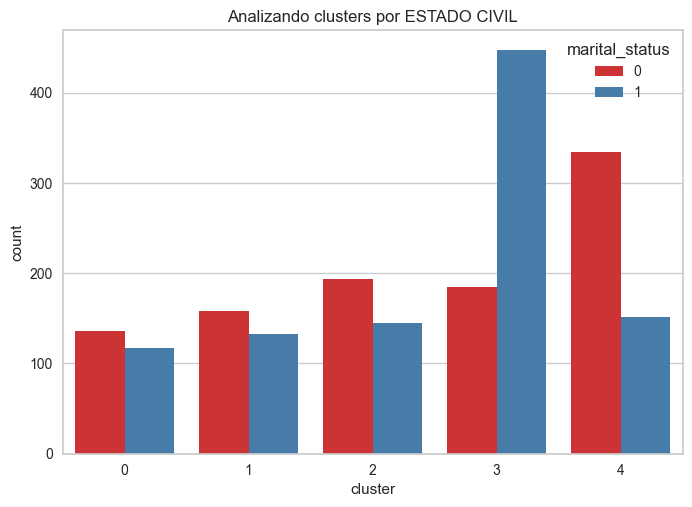

 0 - Solteiro
 1 - Não solteiro


In [27]:
# cluster x estado civil
sns.countplot(data=data, x='cluster', hue='marital_status', palette='Set1')
plt.title('Analizando clusters por ESTADO CIVIL')
plt.show()
print(' 0 - Solteiro\n 1 - Não solteiro')

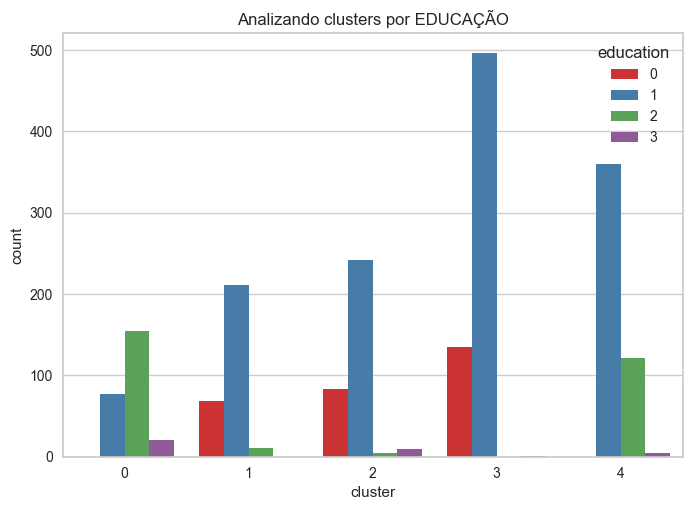

 0 - Desconhecido
 1 - Ensino médio
 2 - Universidade
 3 - Pós-Graduação


In [28]:
# cluster x educação
sns.countplot(data=data, x='cluster', hue='education', palette='Set1')
plt.title('Analizando clusters por EDUCAÇÃO')
plt.show()
print(' 0 - Desconhecido\n 1 - Ensino médio\n 2 - Universidade\n 3 - Pós-Graduação')

In [29]:
data.loc[(data['cluster'] == 3) & (data['education'] == 2)].count()

id                 0
sex                0
marital_status     0
age                0
education          0
income             0
occupation         0
settlement_size    0
cluster            0
dtype: int64

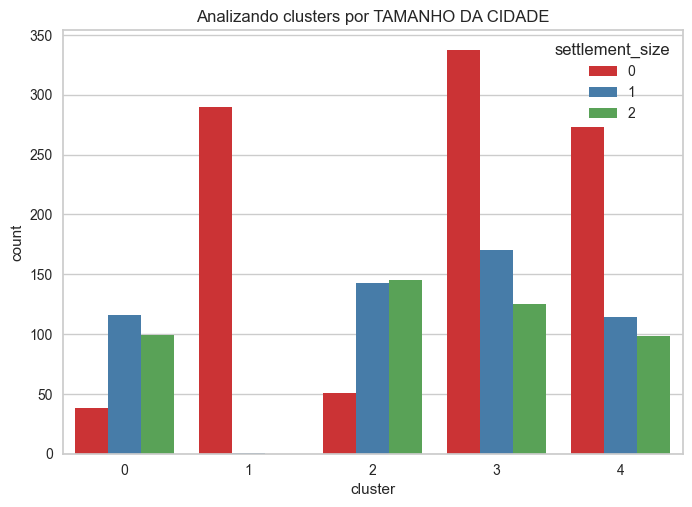

 0 - Cidade Pequena
 1 - Cidade Média
 2 - Cidade Grande


In [30]:
# cluster x tamanho da cidade
sns.countplot(data=data, x='cluster', hue='settlement_size', palette='Set1')
plt.title('Analizando clusters por TAMANHO DA CIDADE')
plt.show()
print(' 0 - Cidade Pequena\n 1 - Cidade Média\n 2 - Cidade Grande')

In [31]:
data['cluster'].value_counts()

cluster
3    632
4    485
2    339
1    291
0    253
Name: count, dtype: int64

In [32]:
# calcula a renda média de cada grupo
data.groupby('cluster')['income'].mean()

cluster
0    12.045562
1    11.161892
2    11.961631
3    11.583528
4    11.632091
Name: income, dtype: float64

## Conclusões:

#### Perfís dos grupos:
- **Grupo 0 (Vermelho)** - Grupo com maior quantidade de homens, baixa taxa de desempregados e grupo com maior quantidade de pessoas altamente qualificadas, em sua maioria são solteiros, níveis de educação equilibrada mas com uma leve majoritariedade para quem tem ensino médio ou é/foi universitário e residem em cidades de médio/grande desenvolvimento.

- **Grupo 1 (Azul)** - Predominantemente feminino, pessoas desempregadas e em maioria solteiras, concentrada no ensino médio e residem em cidade pequena.

- **Grupo 2 (Verde)** - Grupo majoritário masculino, grande parte composto por funcionários qualificados e altamente qualificados, solteiros, possuem ensino médio na sua maioria, e ocupam cidades de médio/grande porte.

- **Grupo 3 (Roxo)** - Grupo majoritário feminino, maior quantidade de profissionais de nível qualificado, grande quantidade de pessoas em um relacionamento, grupo com  a maior quantidade de pessoas com ensino médio nenhum universitário ou pós-graduado, sua maioria se concentra em cidades pequenas mas com uma boa quantidade dividida em cidades de médio/grande porte.

- **Grupo 4 (Laranja)** - Grupo de homens qualificados (em maioria) ou desempregados, solteiros e com ensino médio, maior quantidade reside em cidades pequenas mas com uma boa distribuição em cidades médias ou grandes.

O grupo 0 se destaca porque apresenta pessoas de perfil com um grande poder aquisitivo e um nível de conhecimento acima da média, partindo do ponto de vista de negócios esse será nosso público algo que iremos traballhar com nosso modelo de classificação. Caso esse fosse um projeto real nós teriamos que conmversar com o time de negócios para identificar o perfil que a empresa julga ser o melhor, mas como este projeto é para fins de estudo tomarei a liberdade para escollher o grupo de meu interesse.


____

# Classificação

In [33]:
data_c = pd.read_csv(os.getcwd()+'\\data\\processed\\data_clusterized.csv')
data_c

,id,sex,marital_status,age,education,income,occupation,settlement_size,cluster
0,100000001,0,0,4.204693,2,11.733426,1,2,0
1,100000002,1,1,3.091042,1,11.923531,1,2,2
2,100000003,0,0,3.891820,1,11.398748,0,0,4
3,100000004,0,0,3.806662,1,12.052717,1,1,0
4,100000005,0,0,3.970292,1,11.911910,1,1,0
...,...,...,...,...,...,...,...,...,...
1995,100001996,1,0,3.850148,1,11.724199,0,0,4
1996,100001997,1,1,3.295837,1,11.676268,1,0,3
1997,100001998,0,0,3.433987,0,11.366743,0,0,1
1998,100001999,1,1,3.178054,1,11.492396,0,0,3


- Lembrando que os valores de `age` e `income` estão logatitimados, caso precisemos voltar a escola normal basta elevar expoente.

In [34]:
# transformando clusters na nossa variável alvo
for i in range(len(data_c['cluster'])):
    if data_c['cluster'][i] == 0:
        data_c['cluster'][i] = 1
    else:
        data_c['cluster'][i] = 0

In [35]:
data_c.rename(columns={'cluster' : 'target'}, inplace=True) # renomea coluna

In [36]:
data_c.describe()

,id,sex,marital_status,age,education,income,occupation,settlement_size,target
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,3.532594,1.03800,11.656492,0.810500,0.739000,0.126500
std,5.774946e+02,0.498272,0.500113,0.305600,0.59978,0.306246,0.638587,0.812533,0.332495
min,1.000000e+08,0.000000,0.000000,2.890372,0.00000,10.486597,0.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,3.295837,1.00000,11.489281,0.000000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,3.496508,1.00000,11.657446,1.000000,1.000000,0.000000
75%,1.000015e+08,1.000000,1.000000,3.737670,1.00000,11.835532,1.000000,1.000000,0.000000
max,1.000020e+08,1.000000,1.000000,4.330733,3.00000,12.642274,2.000000,2.000000,1.000000


In [37]:
# removendo coluna 'id' pois não será útil na nossa modelagem
data_c.drop(columns='id', inplace=True)

In [38]:
# exportando dataset
path = 'c:\\Users\\God\\Desktop\\DieGod\\Projetos\\segmentacao-clientes\\data\\processed\\data_target.csv'
data_c.to_csv(path, index=False)

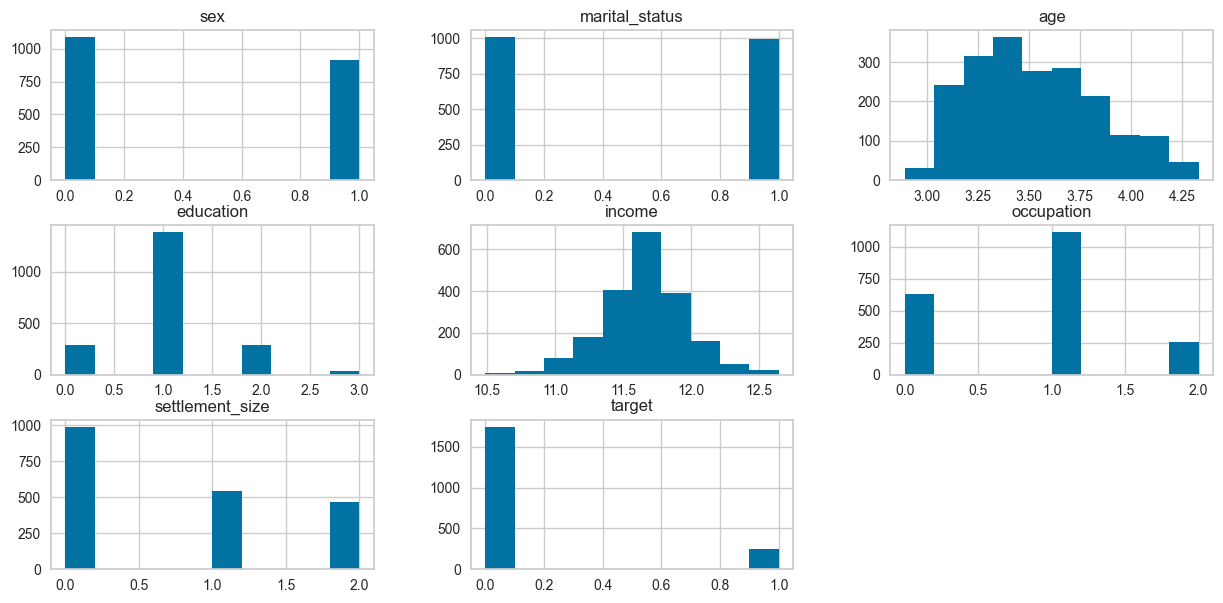

In [39]:
data_c.hist(figsize=(15,7));

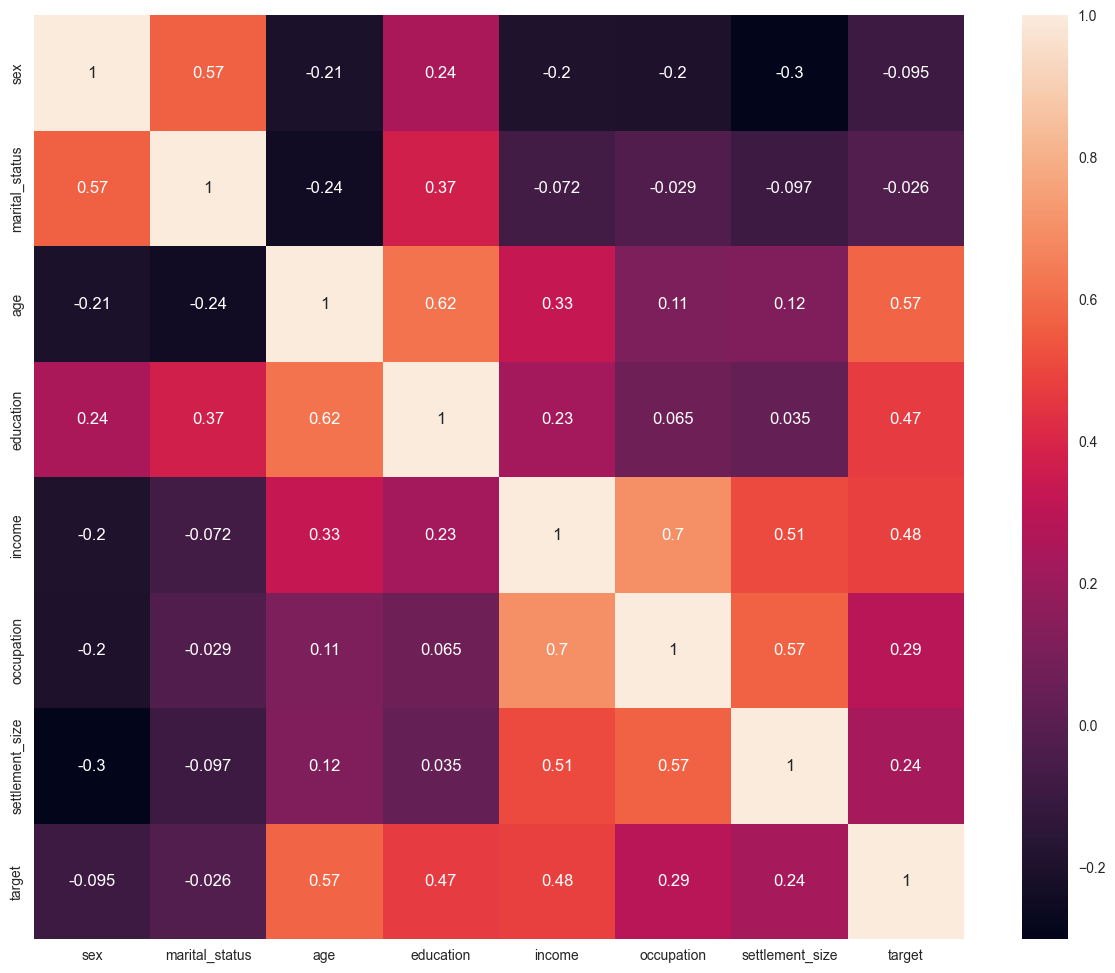

In [40]:
# analizando correlações com a variável alvo
plt.figure(figsize=(15,12))
sns.heatmap(data_c.corr(), annot=True)
plt.show()

- As colunas que apresentam maior correlação com nosso grupo alvo são `age`, `education` e `income`.

In [41]:
# calcula a porcentagem de classe da coluna 'target'
print(f"{(data_c['target'].value_counts() / len(data_c['target']) * 100)}%")

target
0    87.35
1    12.65
Name: count, dtype: float64%


- Percebemos um grande desbalanceamento nas classes alvo, isso deve prejudicar nosso modelo de classificação, portanto seremos obrigados a balancear as classes para um melhor desempenho dos modelos.

- Para resolver esta problema poderemos utilizar meios como OverSampling ou UnderSampling para balancear as classes. Mas há outro fator aqui, possuimos apenas 2000 entradas de dados, o que é uma quantidade muito pequena para utilizar o UnderSample que funciona reduzindo a quantidade da classe majoritária para se equiparar com a minoritária. Isso resultaria em uma perda significativa nos dados, algo que prejudicaria nosso modelo. Como saída para este problema utilizaremos o OverSampling para "criar dados fictícios" na nossa base de treino.

 - Vale lembrar que não podemos utilizar esse método de balanceamento na nosa base de teste, pois nosso objetivo é apenas treinar o modelo fazendo com que ele acerte o máximo possível ao invés de envieza-lo.

In [42]:
# separando treino e teste
x = data_c.drop(columns='target', axis=1)
y = data_c['target']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [43]:
x_train.shape, y_train.shape

((1400, 7), (1400,))

In [44]:
y_train.value_counts()

target
0    1215
1     185
Name: count, dtype: int64

#### Aplicando OverSampling

In [45]:
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train,y_train)

In [46]:
x_train.shape, y_train.shape

((2430, 7), (2430,))

In [47]:
y_train.value_counts()

target
0    1215
1    1215
Name: count, dtype: int64

- Perceba que a quantidade de dados aumentou, isso se deve por que o método de OverSampling criou uma quantidade de dados da categoria minoritária para se igualar à majoritária.

# Modelos de Classificação

In [48]:
# atribui escalonador RobustScaler
r_scaler = RobustScaler()

# define o numero de iterações na nossa validação cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)

## Regressão Logística

#### Treinando modelo

In [49]:
# atribui modelo de Regressão Logística
model_lr = LogisticRegression(random_state=42)

# cria pipeline de processamento
pipeline_lr = make_pipeline(r_scaler, model_lr)

# treina os dados
pipeline_lr.fit(x_train, y_train)

# fazendo previsões nos dados de teste
y_pred_lr = pipeline_lr.predict(x_test)

#### Validando modelo

In [50]:
# calcula acurácia
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# calcula matriz de confusão
cm_lr = confusion_matrix(y_test, y_pred_lr)

# validação cruzada com 5 folds
scores_lr = cross_val_score(pipeline_lr, x_train, y_train, cv=5, scoring = 'accuracy')

#### Vizualizando desempenho

F1-score e Recall
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       532
           1       0.80      0.99      0.88        68

    accuracy                           0.97       600
   macro avg       0.90      0.98      0.93       600
weighted avg       0.98      0.97      0.97       600

--------------------------------------------------------------------------------
A acurácia do modelo de Regressão Logística é 0.97
--------------------------------------------------------------------------------
Validação Cruzada
A acurácia por fold na validação cruzada: [0.96502058 0.97325103 0.97942387 0.9526749  0.97942387]
A acurácia média CV: 0.97
--------------------------------------------------------------------------------


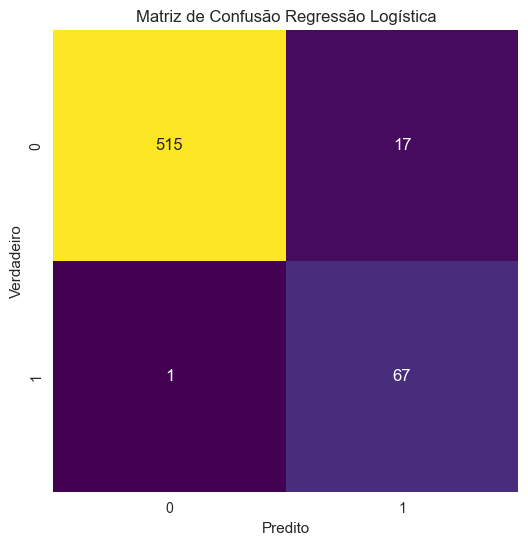

In [51]:
# exibe F1-score e Recall
print('F1-score e Recall')
print(classification_report(y_test, y_pred_lr))
print('-'*80)

# exibe acurácia
print('A acurácia do modelo de Regressão Logística é', accuracy_lr)
print('-'*80)

# exibe validação cruzada
print('Validação Cruzada')
print('A acurácia por fold na validação cruzada:', scores_lr)
print('A acurácia média CV:', round(scores_lr.mean(), 2))
print('-'*80)

# exibe martiz de confusão
plt.figure(figsize=(6,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap=('viridis'), cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão Regressão Logística')
plt.show()


____

## SVM (Support Vector Machine)

#### Treinando o modelo

In [52]:
# criando modelo SVM
model_svm = SVC(kernel='rbf')

# criando pipeline
pipeline_svm = make_pipeline(r_scaler, model_svm)

# ajustando modelo aos dados de treino
pipeline_svm.fit(x_train,y_train)

# fazendo previsões nos dados de teste
y_pred_svm = pipeline_svm.predict(x_test)



#### Validando o modelo

In [53]:
# calculando acurácia
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# calculando matriz de confusão
cm_svm = confusion_matrix(y_test, y_pred_svm)

# validação cruzada com 5 folds
scores_svm = cross_val_score(pipeline_svm, x_train, y_train, cv=5, scoring = 'accuracy')

#### Vizualisando desempenho

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       532
           1       0.89      0.97      0.93        68

    accuracy                           0.98       600
   macro avg       0.94      0.98      0.96       600
weighted avg       0.98      0.98      0.98       600

--------------------------------------------------------------------------------
A acurácia do modelo SVM é: 0.9833333333333333
--------------------------------------------------------------------------------
Validação Cruzada
A acurácia por fold na validação cruzada: [0.97942387 0.98971193 0.99382716 0.97119342 0.98971193]
A acurácia média CV: 0.98
--------------------------------------------------------------------------------


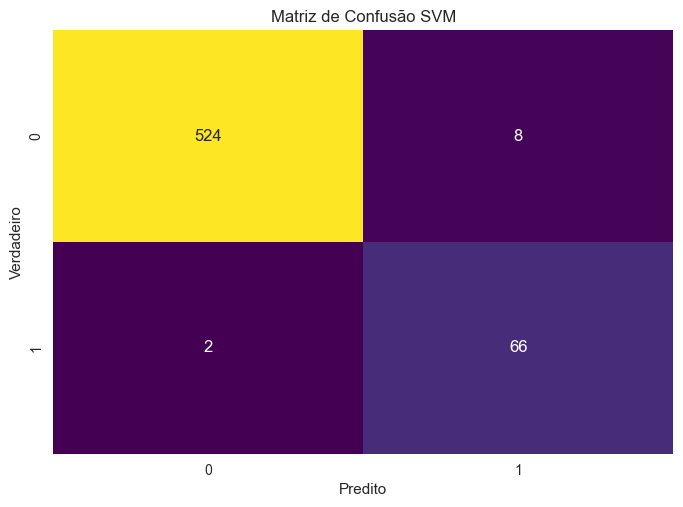

In [54]:
# exibindo F1-Score e Recall
print(classification_report(y_test, y_pred_svm))
print('-'*80)

# exibindo a acurácia
print('A acurácia do modelo SVM é:', accuracy_svm)
print('-'*80)

# exibe validação cruzada
print('Validação Cruzada')
print('A acurácia por fold na validação cruzada:',scores_svm)
print('A acurácia média CV:', round(scores_svm.mean(), 2))
print('-'*80)

# exibe matriz de confusão
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão SVM')
plt.show()



____

## Árvore de Decisão

#### Descobrindo melhores hiperparâmetros

In [55]:
# atribuindo modelo
model_dt = DecisionTreeClassifier(random_state=42)

# definindo hiperparâmetros a serem testados
param_grid_dt = {
    'max_depth': [2, 3, 5, 10, None],
    'min_samples_split': [2,10,20],
    'min_samples_leaf': [ 1,5,10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

# GridSearchCv com validação cruzada em 5 folds
grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid_dt, cv=5, scoring='accuracy',n_jobs=-1)

# ajusta GridSearch aos dados de treino
grid_search_dt.fit(x_train, y_train)

# melhores hiperparâmetros
print('Melhores hiperparâmetros:', grid_search_dt.best_params_)

# melhor pontuação de validação cruzada
print('Melhor acurácia obtida:', grid_search_dt.best_score_)


Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor acurácia obtida: 0.9979423868312758


#### Treinando modelo

In [56]:
# atribuindo modelo com melhores hiperparâmetros
model_dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42)

# criando pipeline de árvore de decisão
pipeline_dt = make_pipeline(r_scaler, model_dt2)

# ajustando modelo aos dados de treino
pipeline_dt.fit(x_train, y_train)

# prevendo dados de teste
y_pred_dt = pipeline_dt.predict(x_test)


#### Avaliando modelo de Árvore de Decisão

In [57]:
# calcula a acurácia
accuracy_dt = accuracy_score(y_test,y_pred_dt)

# calcaula matriz de confusão
cm_dt = confusion_matrix(y_test, y_pred_dt)

# validação cruzada com 5 folds
scores_dt = cross_val_score(pipeline_dt, x_train, y_train, cv=5, scoring = 'accuracy')

#### Vizualizando desempenho

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       532
           1       0.99      0.99      0.99        68

    accuracy                           1.00       600
   macro avg       0.99      0.99      0.99       600
weighted avg       1.00      1.00      1.00       600

--------------------------------------------------------------------------------
A acurácia do modelo de Árvore de Decisão é: 0.9966666666666667
--------------------------------------------------------------------------------
Validação Cruzada
A acurácia por fold na validação cruzada: [0.99794239 0.99588477 1.         0.99588477 1.        ]
A acurácia média CV: 1.0
--------------------------------------------------------------------------------


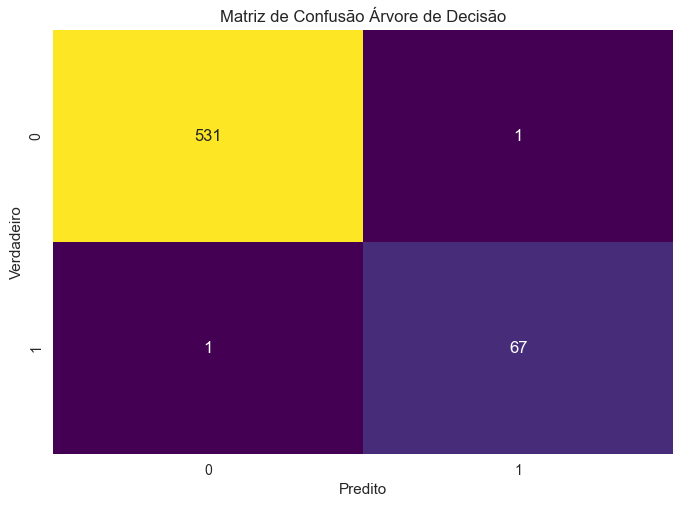

In [58]:
# exibindo F1-Score e Recall
print(classification_report(y_test, y_pred_dt))
print('-'*80)

# exibindo acurácia
print('A acurácia do modelo de Árvore de Decisão é:', accuracy_dt)
print('-'*80)

# exibe validação cruzada
print('Validação Cruzada')
print('A acurácia por fold na validação cruzada:',scores_dt)
print('A acurácia média CV:', round(scores_dt.mean(), 2))
print('-'*80)

# exibindo matriz de confusão
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão Árvore de Decisão')
plt.show()